# Overview

You can either run this as a notebook, changing one variable below, or use the command-line `makepdf.py` script.

# Requirements

 * The standard scientific Python stack, which comes with the [Anaconda](https://store.continuum.io/cshop/anaconda/) Python distribution ... that's what you should be using anyway.
 * [wordcloud](https://github.com/amueller/word_cloud) which can be installed with `pip install git+git://github.com/amueller/word_cloud.git` and requires [PIL](http://effbot.org/imagingbook/pil-index.htm) (PIL comes with the Anaconda Python distribution)
 * [Weasyprint](http://weasyprint.org/). It has some dependencies. You should be able to `pip install weasyprint`.

# Strategy

In the end, we want a nice looking PDF document. There are quite a few tools for generating PDFs. The most popular is [reportlab](https://pypi.python.org/pypi/reportlab) (people seem to recommend reportlab's [platypus](http://www.reportlab.com/apis/reportlab/2.4/platypus.html) for "simple" pdf [generation](https://www.reportlab.com/docs/platypus-example.py)). I wanted something a little easier to control. I thought about using [Markdown](http://daringfireball.net/projects/markdown/syntax) document (see [CommonMark](http://commonmark.org/)) as intermediate format, and using [python-markdown2](https://github.com/trentm/python-markdown2) to generate HTML and [xhtml2pdf](https://github.com/chrisglass/xhtml2pdf) to generate the PDF (similar to what is [done](https://omz-forums.appspot.com/pythonista/post/6427727661891584) [here](https://gist.github.com/SpotlightKid/0efb4d07f28af1c8fc1b)). In the end, it seemed easier to just write out the simple HTML myself. Similarly, I thought about [Sphinx](http://sphinx-doc.org/) with [reStructuredText](http://docutils.sourceforge.net/rst.html), but that needs a working LaTeX environment to produce PDFs.

For the actual HTML to PDF conversoin, some options include xhtml2pdf (which wraps reportlab) and [pdfkit](https://pypi.python.org/pypi/pdfkit) which wraps [wkhtmltopdf](http://wkhtmltopdf.org/). I didn't like the looks of their PDFs, so I went with [Weasyprint](http://weasyprint.org/).

For the wordcloud, I used the free [Raleway](http://www.fontsquirrel.com/fonts/raleway) font, downloaded via [FontSquirrel](http://www.fontsquirrel.com/fonts/list/popular).

# Parsing the Excel

There are a few good Excel parsers these days, but [pandas](http://pandas.pydata.org/) is nice and standard. It also understands XLS files in addition to XLSX, which is important since we don't want to make people convert to XLSX by hand in order to use a different parse.

In this case, we need to know the structure of the XLS documents. There should be two sheets. The first (called "RawData") contains columns like "Path" "CourseCode" etc. and then "Question_1", "Question_2" etc. The second (called "QuestionMapper") contains "Question 1" etc. in column A and the text of the question in column B.

The first row is a header in both cases.

I have no idea how fragile this structure is, so I'll explicitly refer to the sheets by name. That way, there's a decent chance this script will break if someone changes the underlying format.

# Running the thing!

To run this, all you need to do is change the `xl_filename` in the cell below, then run all of the cells.

This will create an HTML file, a wordcloud png, and a PDF all in the same directory as your Excel file.

In [50]:
xl_filename = '/home/kyle/earlham/Phys125/Analytical-Physics-I--(Fall-2015-16).xlsx'

In [51]:
%matplotlib inline
import os
from collections import Counter
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import pandas as pd, numpy as np
from IPython.display import display, HTML 
from weasyprint import HTML as weasyHTML
pdf_filename = os.path.splitext(xl_filename)[0] + '.pdf'
html_filename = os.path.splitext(xl_filename)[0] + '.html'
wc_filename = os.path.splitext(xl_filename)[0] + '-wordcloud.png'
answers = pd.io.excel.read_excel(xl_filename,sheetname='RawData')
questionmap = pd.io.excel.read_excel(xl_filename,sheetname='QuestionMapper')

We want a per-student list of questions and answers. My first thought is to stick everything into a dictionary. We want to make sure to return the results in the correct order, so we could use an ordered dict. I think it's easier just to keep an ordered list of questions.

In [52]:
questions = questionmap["Question"].values

In [53]:
print questions

[u'What were the most positive features of this course?'
 u'What is your assessment of the design, materials and assignments in this course?'
 u'How could this course be improved next time it is offered?'
 u"How well were\xa0[InstructorName] 's objectives (stated or implied) fulfilled?"
 u"What were [InstructorName]'s strongest contributions to this course?"
 u"How could [InstructorName]'s teaching be improved?"
 u'What influence did\xa0[InstructorName] have on your interest in this subject?'
 u'In the space below, please provide a statement about the quality of your performance in this course.'
 u'Students are expected to sign these forms (by adding your name), and should know that unsigned forms are unlikely to be taken seriously by evaluating committees.']


About the below code:

When we iterate through the rows, `idx` is the number of the row, and `qd` comes to us as the "question dictionary" where row 1 is expected to name the columns, and we can then look up entries by name. For example, column A happens to be "Column" and column B is "Question", so asking for `qd['Question']` gets the thing in column B.

`qm` is then my "question map": it maps something like "Question 1" to "What were the most positive features of this course"


In [54]:
#qm will map the column names (Question_1) to question text
qm = {}
for (idx,qd) in questionmap.iterrows():
    qn = qd['Column'].replace(' ','_')
    qt = qd['Question']
    qm[qn] = qt

In [55]:
print qm

{u'Question_3': u'How could this course be improved next time it is offered?', u'Question_2': u'What is your assessment of the design, materials and assignments in this course?', u'Question_1': u'What were the most positive features of this course?', u'Question_7': u'What influence did\xa0[InstructorName] have on your interest in this subject?', u'Question_6': u"How could [InstructorName]'s teaching be improved?", u'Question_5': u"What were [InstructorName]'s strongest contributions to this course?", u'Question_4': u"How well were\xa0[InstructorName] 's objectives (stated or implied) fulfilled?", u'Question_9': u'Students are expected to sign these forms (by adding your name), and should know that unsigned forms are unlikely to be taken seriously by evaluating committees.', u'Question_8': u'In the space below, please provide a statement about the quality of your performance in this course.'}


Now let's grab the data that should be common to all rows

In [56]:
path = answers.Path[0]
course_code = answers.CourseCode[0]
course_title = answers.CourseTitle[0]
instructor_name = answers.InstructorName[0]
instructor_name = instructor_name.encode('ascii','ignore')
enrollments = answers.Enrollments[0]
# We know we're not extracting the following from each row, so keep quiet about it later.
knownskips = ['Path','CourseCode','CourseTitle','UniqueID','InstructorName','Enrollments']

And now let's slurp up the data per student.

In [57]:
a = {}
for (idx,student) in answers.iterrows():
    a[idx] = {}
    for colname in answers.columns:
        col_name = colname.replace(' ','_')
        if col_name in qm:
            #print "Looking up",col_name
            a[idx][qm[col_name]] = student[colname]
        else:
            if colname not in knownskips:
                print "Could not find",colname

Now we're ready to stamp out the text, believe it or not. The only cute thing is that `pandas` uses nan ("not a number") to represent missing data. We'll use `numpy` (imported above as `np`) to test for nan, and turn it into "No answer given."

In [58]:
a[0][questions[0]]

u'Interesting content Labs were fun and made concepts easy to understand'

In [59]:
def is_nan(x): 
    try: return np.isnan(x) 
    except: return False #isnan only eats strings


In [60]:
css = """
p.large-headline {
    font-family: times, Times New Roman, times-roman, georgia, serif;
    color: #444;
    margin: 0px 0px 100px 0px;
    padding: 40px 40px 40px 40px;
    font-size: 55px;
    line-height: 44px;
    letter-spacing: -1px;
    font-weight: bold;
    text-align: center;
    border-radius: 25px;
    border: 2px solid #111;
    width: 90%;
}

p.medium-headline {
    font-family: times, Times New Roman, times-roman, georgia, serif;
    color: #444;
    margin: 0px -10px 0px 0px;
    padding: 0px 0px 0px 0px;
    font-size: 25px;
    line-height: 24px;
    letter-spacing: -1px;
    font-weight: bold;
    text-align: left;
}

p.name {
    font-family: times, Times New Roman, times-roman, georgia, serif;
    font-weight: bold;
    font-size: 20px;
    margin-top: 2em;
    margin-bottom: 0em;
}
p.question {
    font-family: times, Times New Roman, times-roman, georgia, serif;
    font-size: 18px;
    color: #111;
    font-weight: bold;
    margin-top: 0em;
    margin-bottom: 0em;
    width: 90%;
}
p.answer {
    font-family: times, Times New Roman, times-roman, georgia, serif;
    font-size: 18px;
    color: #111;
    text-align: justify;
    margin-top: 0em;
    margin-bottom: 0em;
    width: 90%;
}
table
{
  border-collapse: collapse;
}
th
{
  color: #ffffff;
  background-color: #000000;
}
td
{
  background-color: #cccccc;
}
table, th, td
{
  font-family:Arial, Helvetica, sans-serif;
  border: 1px solid black;
  text-align: right;
}
"""

In [61]:
html = '''
<html>
<head>
<style>
{css}
</style>
</head>
<body>
<div>
<p class="large-headline">{title}</p>
<p class="medium-headline">{code}<br>{instructor}<br>Answers from {a} of {b} enrolled students</p>
<div>'''.format(css=css,
    title=course_title,code=course_code,instructor=instructor_name,
    a=len(a),b=enrollments
)

In [62]:
answertext = ''
for idx in sorted(a):
    html += '''<div class="response">
    <p class="name">Student {i} ({n})</p>
    '''.format(
            i=idx+1, n=a[idx][questions[-1]]
        )
    for question in questions[:-1]:
        question_cor_name = question.replace("[InstructorName]", instructor_name)
        if u'\xa0' in question_cor_name: 
            question_cor_name = question_cor_name.replace(u'\xa0', u' ') #Corrects for unicode encoding error
        answer = a[idx][question]  
        if is_nan(answer):
            answer = 'No answer given.'
        else:
            answer = answer.lower()
            answertext = answertext + ' ' + answer
        if u'\xe9' in answer:
            answer = answer.replace(u'\xe9','e') 
        html += '''<p class="question">{q}</p>
        <p class="answer">{a}</p>
        '''.format(q=question_cor_name,a=answer)
    html += '</div>'

Adding some words to ignore list in the WordCloud

In [63]:
[first_name, last_name] = instructor_name.split(' ')
STOPWORDS_additions = [first_name.lower(),first_name.lower()+"'s",last_name.lower(),'us','thing','will']
STOPWORDS_removals = []
STOPWORDS = STOPWORDS.union(STOPWORDS_additions)
STOPWORDS = STOPWORDS.difference(STOPWORDS_removals)

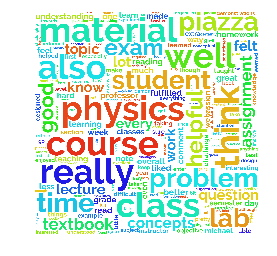

In [64]:
#fig = plt.figure(figsize=(18,14))
wordcloud = WordCloud(
                      font_path='Fonts/Raleway-Bold.ttf',
                      stopwords=STOPWORDS,
                      background_color='white',
                      width=3000,
                      height=3000
                     ).generate(answertext)
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig(wc_filename, dpi=600)

In [65]:
c = Counter([i for i in answertext.lower().split() if i not in STOPWORDS])
#for (w,n) in c.most_common(20):
#    print "{w:20s}: {n:4d}".format(w=w,n=n)

In [66]:
html += '''<div class="content-analysis">
<img src="{wc}" style="width:720px;height:560px;"/>
<table>
  <caption>Most common words</caption>
  <tr><th>Word</th><th>Count</th></tr>
'''.format(wc=os.path.split(wc_filename)[-1])
for (w,n) in c.most_common(20):
    html += '<tr><td>{w}</td><td>{n}</td></tr>\n'.format(w=w,n=n)
html += '''</table>
</div>
</body>
</html>'''

In [67]:
open(html_filename,'w').write(html)

In [68]:
display(HTML(html.replace(os.path.split(wc_filename)[-1],wc_filename))) 

Word,Count
class,47
course,33
think,32
physics,30
really,27
also,25
class.,23
well,22
students,20
piazza,18


In [69]:
#!weasyprint "{html_filename}" "{pdf_filename}"

In [70]:
weasyHTML(html_filename).write_pdf(pdf_filename)